# Sprint 3: MVP - Engenharia de dados
## Professor: Victor Almeida
## Aluno: Leonard Ravaglia Pereira
## Avaliação sobre o conjunto de dados dos jogos olímpicos de 1896 a 2016

%md
# 1. Introdução

Este trabalho é apresentado como entrega final do MBA em Ciência de Dados, módulo de Engenharia de Dados, promovido pela Pontifícia Universidade Católica do Rio de Janeiro.

## 1.1. Contextualização da proposta

As Olimpíadas são um evento esportivo que mobilizam diversas nações ao redor do mundo. Diversos esportes já tiveram suas competições integradas permanentemente, outras de forma intermitente e algumas foram convidadas em casos isolados.
O evento não traz apenas audiência, mas também incentiva uma vida saudável e fortalece os laços de união entre os povos, seguindo a filosofia do barão de Coubertain.
Esse ano de 2024, os jogos serão realizados em Paris, e é nesse cenário que despertou o interesse na construção desse trabalho.

## 1.2. Objetivo

O objetivo deste trabalho é explorar as curiosidades por trás dos jogos. Há diversas possibilidades de análise, dada a quantidade de nacionalidades, características dos atletas enolvidos.
Para isso, serão realizadas diversas consultas e avaliações nas bases.
Além disso, será avaliada a modelagem dos dados e outras informações relevantes.

%md
# 2. Perguntas elaboradas para atender os objetivos definidos


1. Qual o atleta mais pesado de todos os tempos?
2. Qual a idade mais frequente dos medalhistas?
3. Qual é a altura média de um medalhista de ouro em cada esporte?
4. Quais os esportes com maior participação nos jogos?
5. Qual o atleta brasileiro participou de mais jogos?

%md
# 3. Coleta de dados:
Os arquivos abaixo foram baixados do Kaggle, de forma manual, através do link: https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results.
A base é composta de apenas dois arquivos.
- athlete_events.csv
- noc_regions.csv

Foi utilizado o ambiente do Databricks Community para execução das etapas de ETL.

## 3.1 Criando o cluster para processamento.



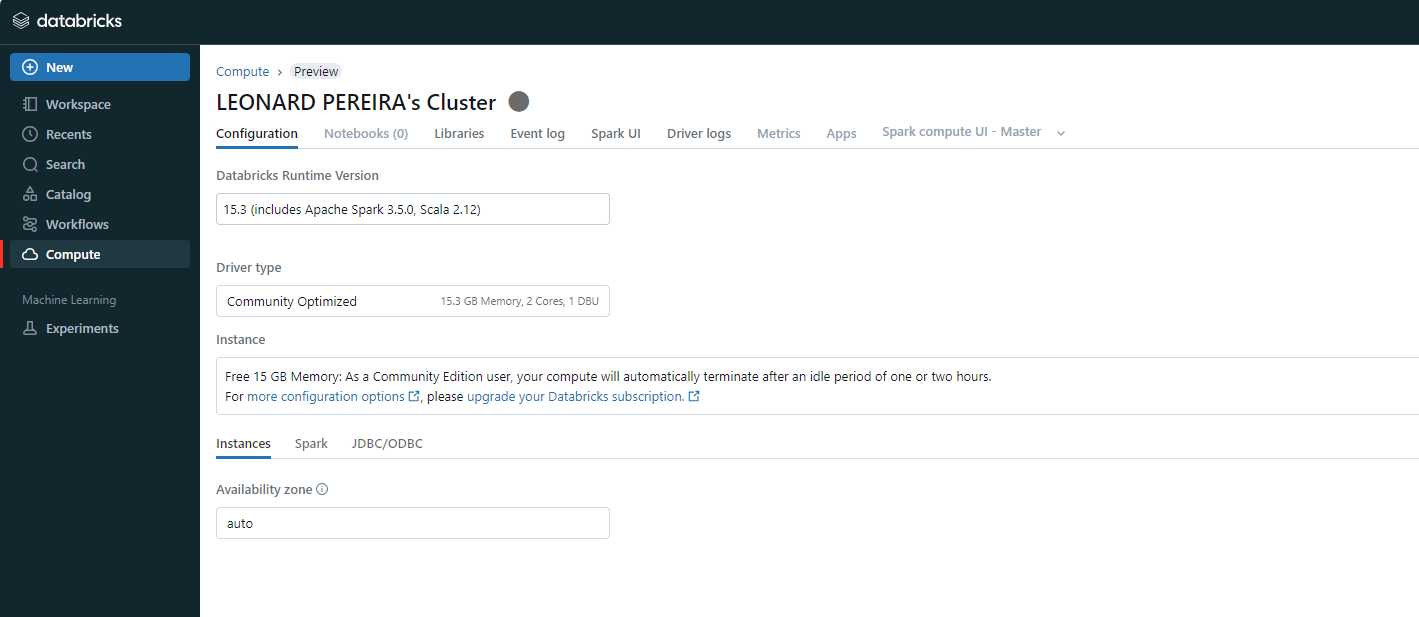

## 3.2 Upload dos arquivos
Para o Upload do CSV, foi utilizada a opção Create Table with UI

https://github.com/leonardevop/Engenharia-de-Dados/blob/71194a735e43b2e908397bc3c769cbee580a6bfc/Telas/Cluster.png

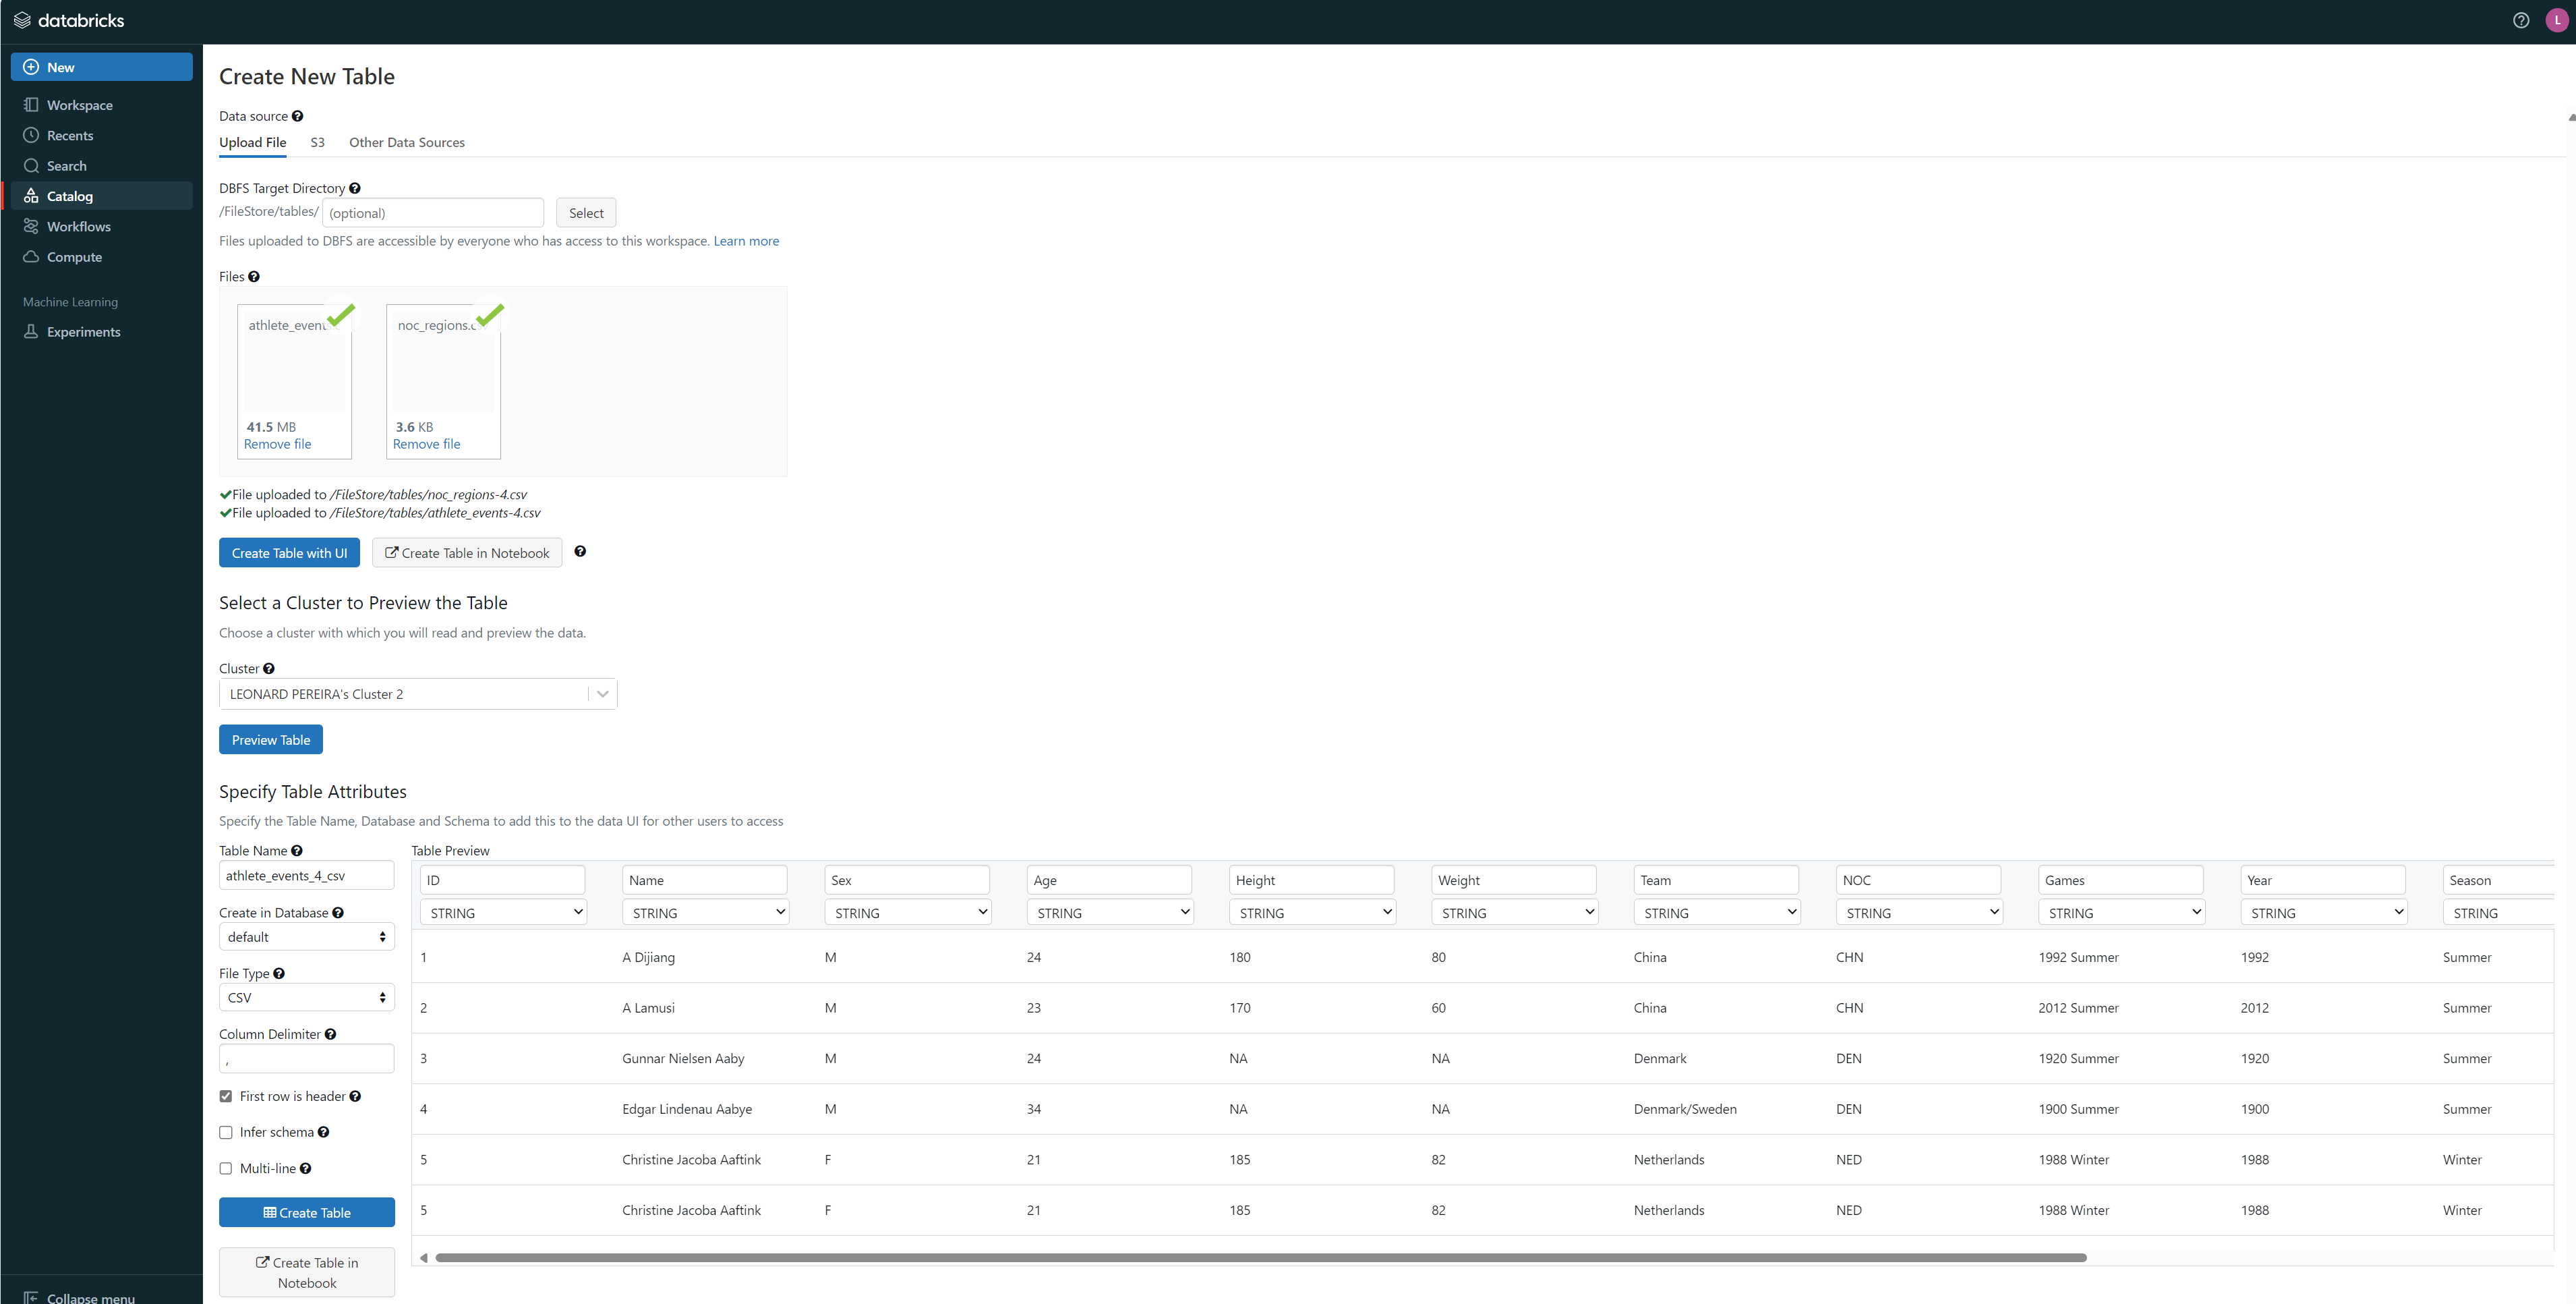

Em seguida fazemos a modelagem dos dados

### 4.2 Modelagem dos dados

O Databricks realizou a modelagem dos dados através da interface do usuário, resultado no tratamento abaixo.
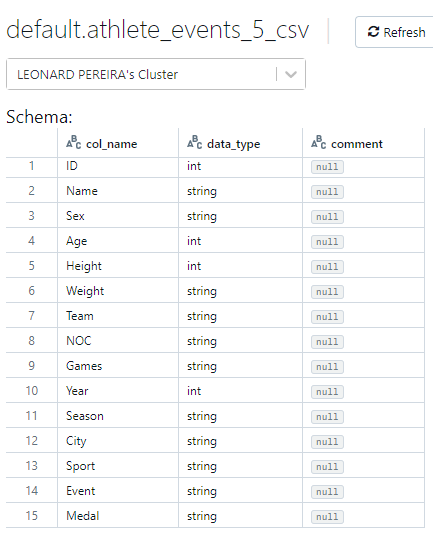

Através desse esquema, e do conjunto de algumas consultas podemos fazer algumas análises sintáticas e semânticas.

Há dados de característica de inteiro que foram classificados como strings, o que sugere a possibilidade de haver problemas na qualidade dos dados.

Outro fator notável, é que não há a identificação das medidas dos dados de altura e peso. Pelos valores, deduzimos que se tratam de centímetros e quilos.
https://github.com/leonardevop/Engenharia-de-Dados/blob/71194a735e43b2e908397bc3c769cbee580a6bfc/Telas/medidas.png

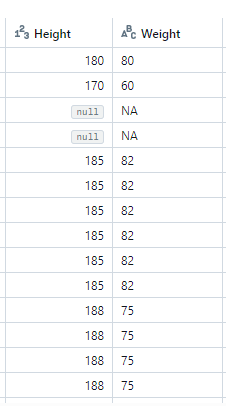

Além disso podemos identificar que o conjunto de dados está limitado ao ano de 1896 a 2016.

https://github.com/leonardevop/Engenharia-de-Dados/blob/71194a735e43b2e908397bc3c769cbee580a6bfc/Telas/incio.png
https://github.com/leonardevop/Engenharia-de-Dados/blob/71194a735e43b2e908397bc3c769cbee580a6bfc/Telas/fim.png



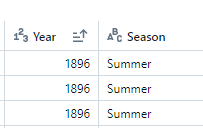
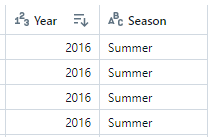

### 4.2.1 Catálogo de dados



Sugerimos o glossário de dados com as seguintes descrições:
1.   ID: Identificador único para cada atleta na tabela.
2.   Name: Nome do atleta.
3.   Sex: Gênero do atleta.
4.   Age: Idade do atleta durante os Jogos Olímpicos.
5.   Height: Altura do atleta em centímetros.
5.   Weight: Peso do atleta em quilogramas.
7.   Team: Nome do time ou nação representada pelo atleta.
8.   NOC: Código do Comitê Olímpico Nacional ao qual o atleta está associado.
9.   Games: Nome dos Jogos Olímpicos.
10.  Year: Ano em que os Jogos Olímpicos ocorreram.
11.  Season: Estação em que os Jogos Olímpicos ocorreram (verão ou inverno).
12.  City: Nome da cidade onde os Jogos Olímpicos ocorreram.
13.  Sport: Nome do esporte em que o atleta competiu.
14.  Event: Nome específico do evento dentro do esporte.
15.  Medal: Medalha conquistada pelo atleta (ouro, prata, bronze ou nenhuma).

## 5. Análise de Datasets

### 5.1 Qualidade dos dados

Podemos identificar que o conjunto dos dados contempla esportes antigos e, em função dos recursos e registros da época, há a possibilidade de haver ausência de muitas informações para esses períodos.

Dado que nosso objetivo é identificar curiosidades, a ausência de informações não comprometem o trabalho. As curiosidades só existem sobre aquilo que é documentado, portanto, não há a necessidade de preencher ou tratar dados em sua origem. É possível ajustar esses pontos pelos filtros das consultas.

Na consulta abaixo, verificamos a distribuição de dados válidos e não válidos sobre o total de registros das colunas de peso e altura.


In [0]:
%sql
SELECT 
    COUNT(CASE WHEN Height IS NULL THEN 1 END) AS registros_nulos,
    COUNT(*) AS total_registros
FROM athlete_events_5_csv;

registros_nulos,total_registros
60171,271116


Podemos verificar que há ausência de dados de altura em uma proporção de 22%.

Para os dados de peso, é necessária uma outra abordagem, dado que a coluna foi modelada como string.

In [0]:
%sql
SELECT 
    COUNT(CASE WHEN TRY_CAST(Weight AS DECIMAL) IS NOT NULL THEN 1 END) AS registros_inteiros,
    COUNT(CASE WHEN TRY_CAST(Weight AS DECIMAL) IS NULL AND Weight IS NOT NULL THEN 1 END) AS registros_strings,
    COUNT(Weight) AS total_registros
FROM athlete_events_5_csv;

registros_inteiros,registros_strings,total_registros
208241,62875,271116


Pelo volume de dados em strings, será necessário realizar uma alteração no tipo de dado dessa coluna, visando a facilitação das consultas seguintes. Para tanto, de maneira a não comprometer a estrutura dos dados faremos o seguinte tratamento:
Faça um backup dos seus dados antes de fazer qualquer alteração na estrutura da tabela.

Faremos a transformação da tabela usando o spark e será criada uma nova tabela. As consultas anteriores não necessitam ser refeitas

In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

# Carrega a tabela
tabela = spark.table("athlete_events_5_csv")

# Define a função de conversão
def convert_weight(weight):
    try:
        return int(weight)
    except:
        return None

# Cria uma função UDF (User-Defined Function)
convert_weight_udf = udf(convert_weight, IntegerType())

# Aplica a função de conversão na coluna e atualiza a tabela
tabela = tabela.withColumn("new_weight", convert_weight_udf(col("Weight").cast("string")))
tabela = tabela.drop("Weight").withColumnRenamed("new_weight", "Weight")

# Salva a tabela atualizada
tabela.write.mode("overwrite").saveAsTable("athlete_events_6_csv")

Faremos uma conferência para identificar a qualidade dos dados após o tratamento

In [0]:
from pyspark.sql.functions import col

# Carrega a tabela
tabela = spark.table("athlete_events_6_csv")

# Conta a quantidade de registros nulos na coluna "Weight"
quantidade_registros_nulos = tabela.filter(col("Weight").isNull()).count()

print("Quantidade de registros nulos na coluna 'Weight':", quantidade_registros_nulos)

Quantidade de registros nulos na coluna 'Weight': 63933


Podemos identificar que a ausência de informações na coluna weight continua alta. Portanto, teremos uma quantidade menor de registros para avaliar.

Vamos analistar agora os dados da coluna de idade.

In [0]:
%sql
SELECT 
    COUNT(CASE WHEN Age IS NULL THEN 1 END) AS registros_nulos,
    COUNT(*) AS total_registros
FROM athlete_events_5_csv;

registros_nulos,total_registros
9474,271116


Para a coluna idade o volume é bem menor.

Vejamos a distribuição da ausência desses dados para identificarmos o período em que houve a ausência.

In [0]:
%sql
SELECT Year, COUNT(*) AS Null_Age_Count
FROM athlete_events_5_csv
WHERE Age IS NULL
GROUP BY Year
ORDER BY Null_Age_Count DESC;

Year,Null_Age_Count
1948,1176
1924,1142
1928,963
1920,845
1900,790
1906,743
1908,649
1956,638
1932,330
1952,277


Como previsto, a ausência refere-se aos períodos mais antigos, porém ainda perdura até 1960, sem no entanto comprometer o escopo do trabalho.

No entanto, consideramos as informações das colunas de ano, país, cidade e esporte fundamentais para identificar os cenários corretos.

In [0]:
%sql
SELECT 
    SUM(CASE WHEN Team IS NULL THEN 1 ELSE 0 END) AS Null_Team,
    SUM(CASE WHEN Year IS NULL THEN 1 ELSE 0 END) AS Null_Year,
    SUM(CASE WHEN City IS NULL THEN 1 ELSE 0 END) AS Null_City,
    SUM(CASE WHEN Sport IS NULL THEN 1 ELSE 0 END) AS Null_Sport
FROM athlete_events_5_csv;


Null_Team,Null_Year,Null_City,Null_Sport
0,0,0,0


Como podemos perceber, não há ausência de informação nessas colunas.

Há um outro ponto para verificarmos se os dados estão consistentes. É preciso identificar se todos os esportes tem seus medalhistas de ouro, prata e bronze identificados. Na cunsulta abaixo buscamos identificar se há alguma medalha ausente em alguma das modalidades disputadas. 

In [0]:
%sql
SELECT Year, Event,
    CASE
        WHEN COUNT(CASE WHEN Medal = 'Gold' THEN 1 END) = 0 THEN 'Gold'
        WHEN COUNT(CASE WHEN Medal = 'Silver' THEN 1 END) = 0 THEN 'Silver'
        WHEN COUNT(CASE WHEN Medal = 'Bronze' THEN 1 END) = 0 THEN 'Bronze'
    END AS Missing_Medal
FROM athlete_events_5_csv
GROUP BY Year, Event
HAVING 
    COUNT(CASE WHEN Medal = 'Gold' THEN 1 END) = 0
    OR COUNT(CASE WHEN Medal = 'Silver' THEN 1 END) = 0
    OR COUNT(CASE WHEN Medal = 'Bronze' THEN 1 END) = 0
ORDER BY Year, Event;

Year,Event,Missing_Medal
1896,Athletics Men's 110 metres Hurdles,Bronze
1896,Athletics Men's High Jump,Bronze
1896,Cycling Men's 100 kilometres,Bronze
1896,Cycling Men's 12-Hours Race,Bronze
1896,"Fencing Men's Foil, Masters, Individual",Bronze
1896,Gymnastics Men's Horizontal Bar,Bronze
1896,"Gymnastics Men's Horizontal Bar, Teams",Silver
1896,Gymnastics Men's Parallel Bars,Bronze
1896,"Gymnastics Men's Parallel Bars, Teams",Silver
1896,Gymnastics Men's Pommelled Horse,Bronze


Apesar de haver modalidades na olimpíada que não disputam medalhas, podemos verificar que há ausência de registros ainda recentes, o que pode comprometer uma análise mais precisa. Para tratamento, seria necessário checar outras bases de dados similares, visando o preenchimento dessas lacunas. Para fins de mensuração, vejamos qual a proporação dessas ausências.

In [0]:
%sql
SELECT
    COUNT(CASE WHEN Medal = 'Gold' THEN 1 END) AS Total_Gold,
    COUNT(CASE WHEN Medal = 'Silver' THEN 1 END) AS Total_Silver,
    COUNT(CASE WHEN Medal = 'Bronze' THEN 1 END) AS Total_Bronze,
    COUNT(*) AS Total_Medals
FROM athlete_events_5_csv
WHERE Medal IN ('Gold', 'Silver', 'Bronze');

Total_Gold,Total_Silver,Total_Bronze,Total_Medals
13372,13116,13295,39783


Dessa forma, vemos que temos 205 medalhas perdidas de um total de 39783 medalhas. Além da maior concentração nos períodos antigos, a proporção é reduzida. Iremos ignorar esse volume e prol da continuidade do trabalho.

Em seguida, vejamos os valores máximos e mínimos das colunas idade, altura e peso, para checar se há discrepâncias.

In [0]:
%sql

SELECT
(SELECT MAX(CAST(Weight AS INTEGER)) FROM athlete_events_5_csv) AS max_weight,
(SELECT MIN(CAST(Weight AS INTEGER)) FROM athlete_events_5_csv) AS min_weight;

max_weight,min_weight
214,25


In [0]:
%sql
SELECT
(SELECT MAX(CAST(Height AS INTEGER)) FROM athlete_events_5_csv) AS max_height,
(SELECT MIN(CAST(Height AS INTEGER)) FROM athlete_events_5_csv) AS min_height;

max_height,min_height
226,127


In [0]:
%sql
SELECT
(SELECT MAX(CAST(Age AS INTEGER)) FROM athlete_events_5_csv) AS max_age,
(SELECT MIN(CAST(Age AS INTEGER)) FROM athlete_events_5_csv) AS min_age;

max_age,min_age
97,10


A distribuição parece coerente. Apesar do peso mínimo extremamente baixo para um atleta olímpico, o valor é coerente com a idade mínima apontada para os atletas.

## 5.2 Avaliação sobre as questões iniciais

Conforme se pode verificar, é possível tratar os problemas através das próprias consultas. Dessa forma, faremos uma avaliação sobre os dados buscando atender as curiosidades despertadas incialmente.

Nessa consulta podemos verificar que os esportes que lideram o ranking eram esperados, porém o polo aquático e o baseball aparecem curiosamente entre os que possuem atletas mais altos.

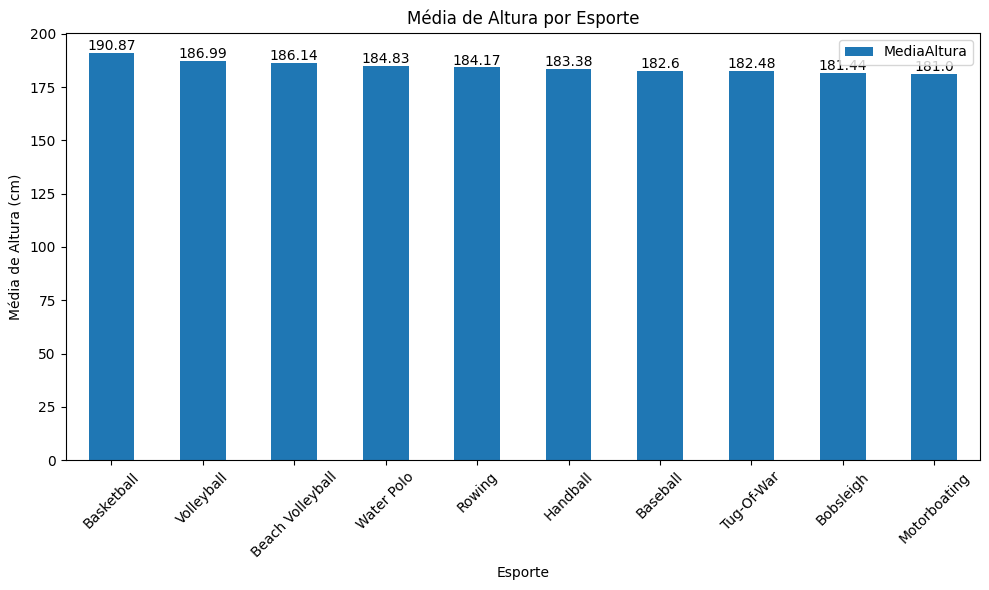

In [0]:
# Gerar o gráfico de barras com Média de altura dos 10 esportes mais altos
ax = df_pandas.plot(x='Sport', y='MediaAltura', kind='bar', figsize=(10, 6))
plt.xlabel('Esporte')
plt.ylabel('Média de Altura (cm)')
plt.title('Média de Altura por Esporte')
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionar os valores em cada barra
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Exibir o gráfico
plt.show()

Nessa consulta podemos ver a participação brasileira nos jogos para os 20 esportes com maior volume de atletas. Os esportes coletivos prevalecem, porém natação e atletismo se destacam pelo grande volume de modalidades.

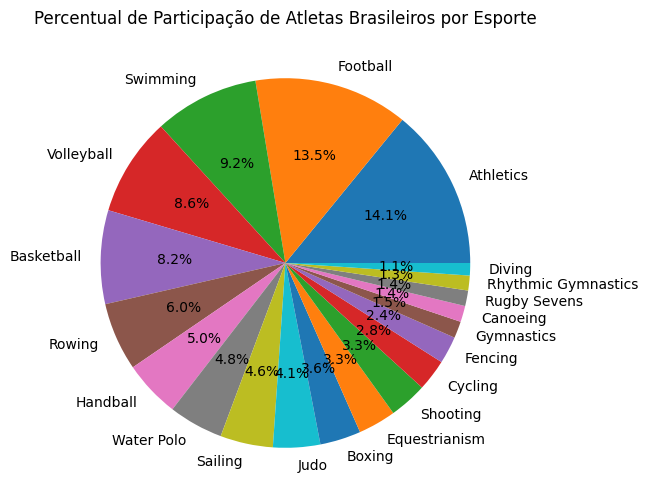

In [0]:
# Consulta SQL para obter o percentual de participação de atletas brasileiros por esporte (limitado a 20 esportes)
df = spark.sql("SELECT Sport, COUNT(DISTINCT Name) AS Quantidade FROM athlete_events_5_csv WHERE Team = 'Brazil' GROUP BY Sport ORDER BY Quantidade DESC LIMIT 20")

# Converter o resultado da consulta para um DataFrame pandas
df_pandas = df.toPandas()

# Gerar o gráfico em pizza
plt.figure(figsize=(10, 6))
plt.pie(df_pandas['Quantidade'], labels=df_pandas['Sport'], autopct='%1.1f%%')
plt.title('Percentual de Participação de Atletas Brasileiros por Esporte')

# Exibir o gráfico
plt.show()

In [0]:
!pip install wordcloud

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/40/ad/c22887189c23cc133ae7cbad48c71312f1a962b960fe7f51fd792808a307/wordcloud-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/548.3 kB ? eta -:--:--
   ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/548.3 kB 3.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 399.4/548.3 kB 6.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 6.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Nessa visão em nuvem podemos consultar o maior volume de atletas por esporte.

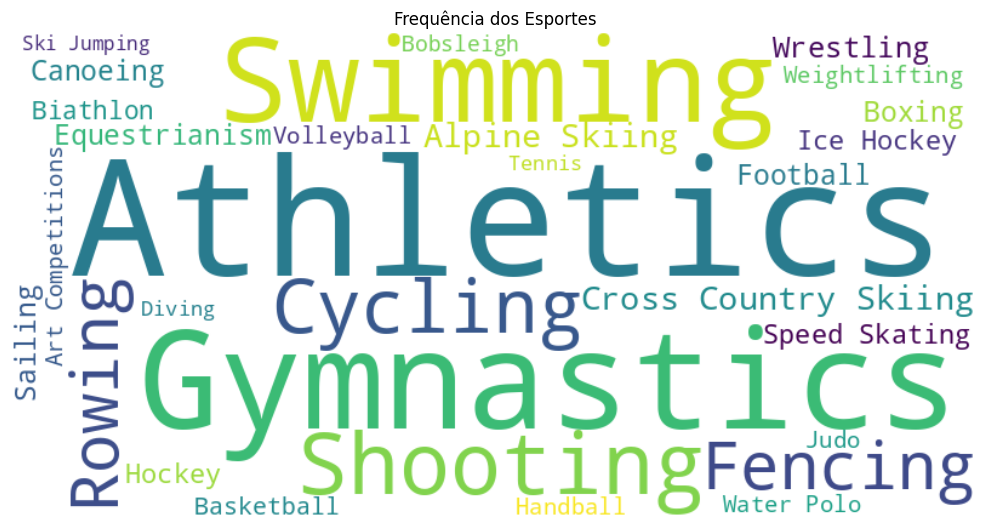

In [0]:
# Importar bibliotecas necessárias
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Consulta SQL para obter a frequência dos esportes
df_esportes = spark.sql("SELECT Sport, COUNT(*) AS Frequencia FROM athlete_events_5_csv GROUP BY Sport ORDER BY Frequencia DESC LIMIT 30")

# Converter o resultado da consulta para um DataFrame pandas
df_pandas = df_esportes.toPandas()

# Criar um dicionário com os esportes e suas frequências
esportes_dict = dict(zip(df_pandas['Sport'], df_pandas['Frequencia']))

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(esportes_dict)

# Plotar a nuvem de palavras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequência dos Esportes')
plt.tight_layout()

# Exibir o gráfico
plt.show()

Nessa consulta, buscamos identificar os esportes com a idade mais comum entre os atletas de cada esporte, limitada as 10 maiores idades e as 10 menores idades.

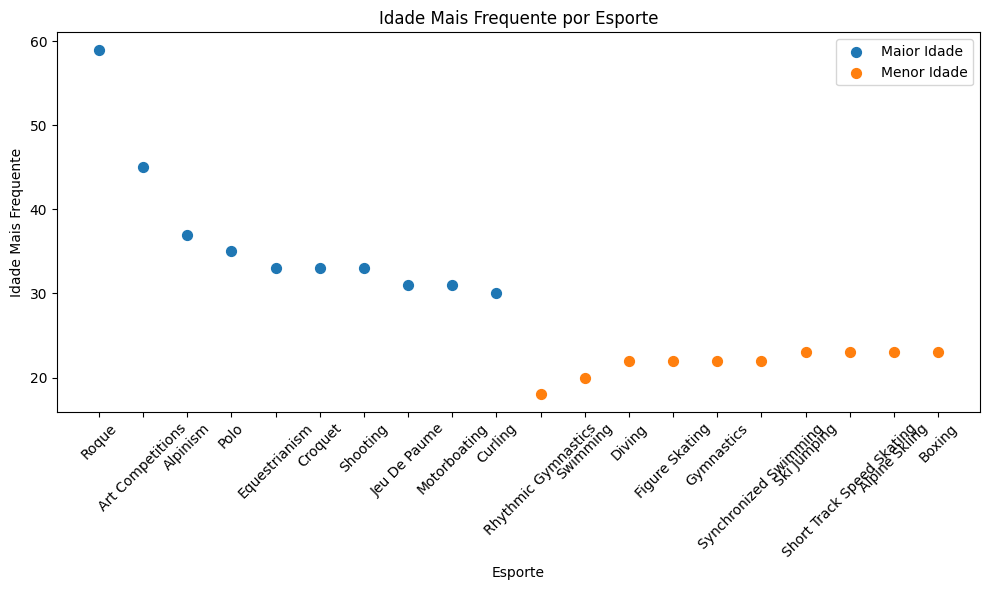

In [0]:
# Consulta SQL para obter a idade mais frequente por esporte
df_idade_esporte = spark.sql("SELECT Sport, percentile_approx(Age, 0.5) AS IdadeFrequente FROM athlete_events_5_csv GROUP BY Sport ORDER BY IdadeFrequente DESC LIMIT 10")
df_idade_esporte_menor = spark.sql("SELECT Sport, percentile_approx(Age, 0.5) AS IdadeFrequente FROM athlete_events_5_csv GROUP BY Sport ORDER BY IdadeFrequente ASC LIMIT 10")

# Converter o resultado da consulta para um DataFrame pandas
df_pandas = df_idade_esporte.toPandas()
df_pandas_menor = df_idade_esporte_menor.toPandas()

# Gerar o gráfico
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['Sport'], df_pandas['IdadeFrequente'], s=50, label='Maior Idade')
plt.scatter(df_pandas_menor['Sport'], df_pandas_menor['IdadeFrequente'], s=50, label='Menor Idade')
plt.xlabel('Esporte')
plt.ylabel('Idade Mais Frequente')
plt.title('Idade Mais Frequente por Esporte')
plt.xticks(rotation=45)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

Consulta para verificar os 10 atletas mais pesados de todos os tempos. O gráfico apresentou uma inconsistência, só sendo possível visualizar os 8 atletas mais pesados.


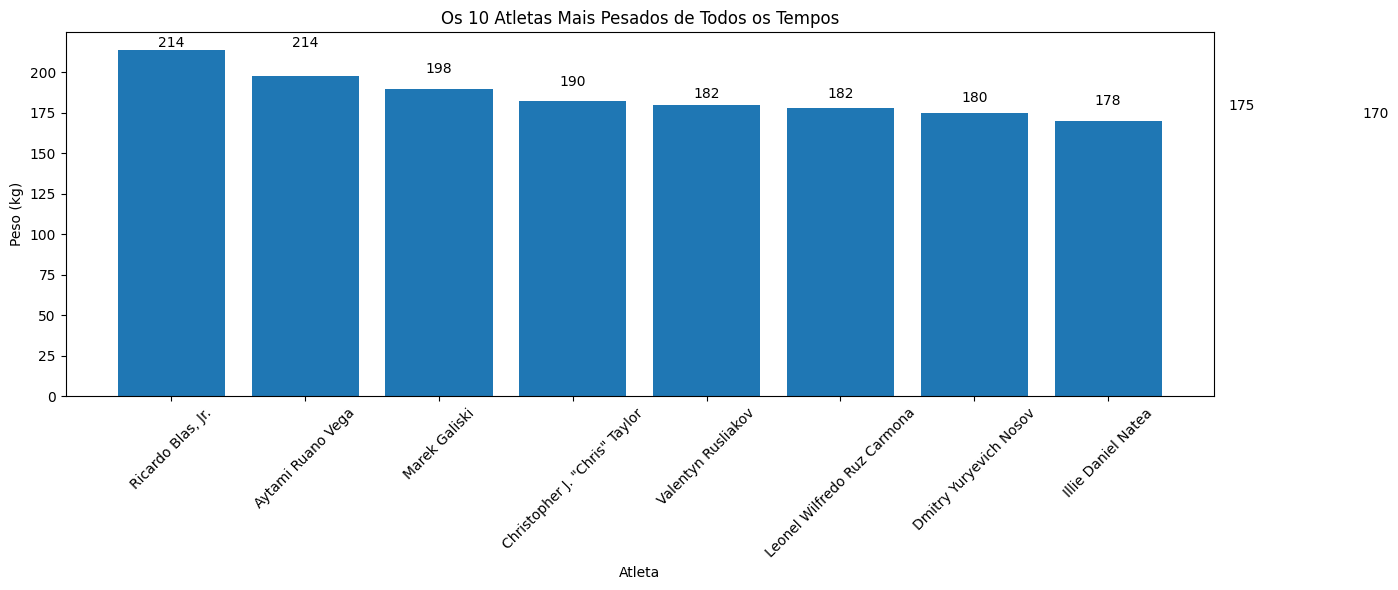

In [0]:
# Consulta SQL para obter os 10 atletas mais pesados de todos os tempos
df_atletas_pesados = spark.sql("SELECT Name, CAST(Weight AS INT) AS Weight FROM athlete_events_6_csv WHERE Weight IS NOT NULL AND Weight % 1 = 0 ORDER BY Weight DESC LIMIT 10")

# Converter o resultado da consulta para um DataFrame pandas
df_pandas = df_atletas_pesados.toPandas()

plt.figure(figsize=(14, 6))

# Gerar o gráfico
plt.bar(df_pandas['Name'], df_pandas['Weight'])
plt.xlabel('Atleta')
plt.ylabel('Peso (kg)')
plt.title('Os 10 Atletas Mais Pesados de Todos os Tempos')

for i, v in enumerate(df_pandas['Weight']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Exibir o gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nessa consulta podemos ver a distribuição da idade entre os medalhistas de ouro, sendo a idade dos 23 anos a mais ferquente entre os medalhistas.

/root/.ipykernel/16316/command-3917360997611872-2205605733:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


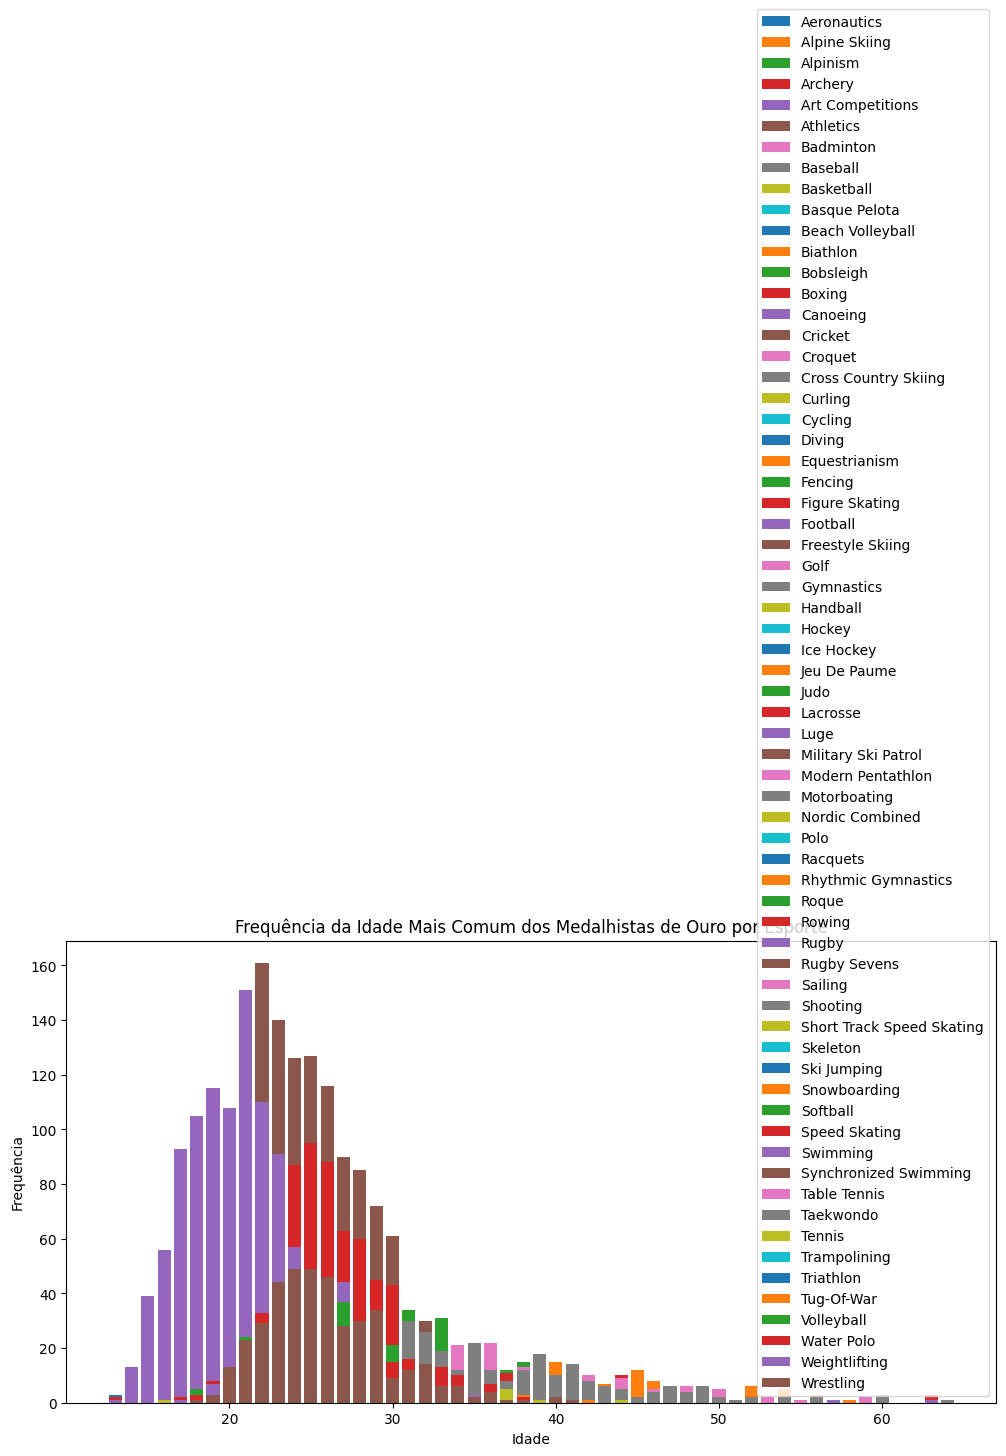

In [0]:
# Consulta SQL para obter a frequência da idade mais comum dos medalhistas de ouro por esporte
df_frequencia_idade = spark.sql("SELECT Sport, Age, COUNT(*) AS Frequencia FROM athlete_events_5_csv WHERE Medal = 'Gold' GROUP BY Sport, Age HAVING COUNT(*) > 0 ORDER BY Sport, Frequencia DESC")

# Converter o resultado
df_pandas = df_frequencia_idade.toPandas()

# Gerar o gráfico
plt.figure(figsize=(12, 6))
for sport in df_pandas['Sport'].unique():
    df_sport = df_pandas[df_pandas['Sport'] == sport]
    plt.bar(df_sport['Age'], df_sport['Frequencia'], label=sport)

plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.title('Frequência da Idade Mais Comum dos Medalhistas de Ouro por Esporte')
plt.legend()
plt.tight_layout()

# Exibir o gráfico
plt.show()

Nessa curiosidade, identificamos os esportes que participaram de mais jogos olímpicos.

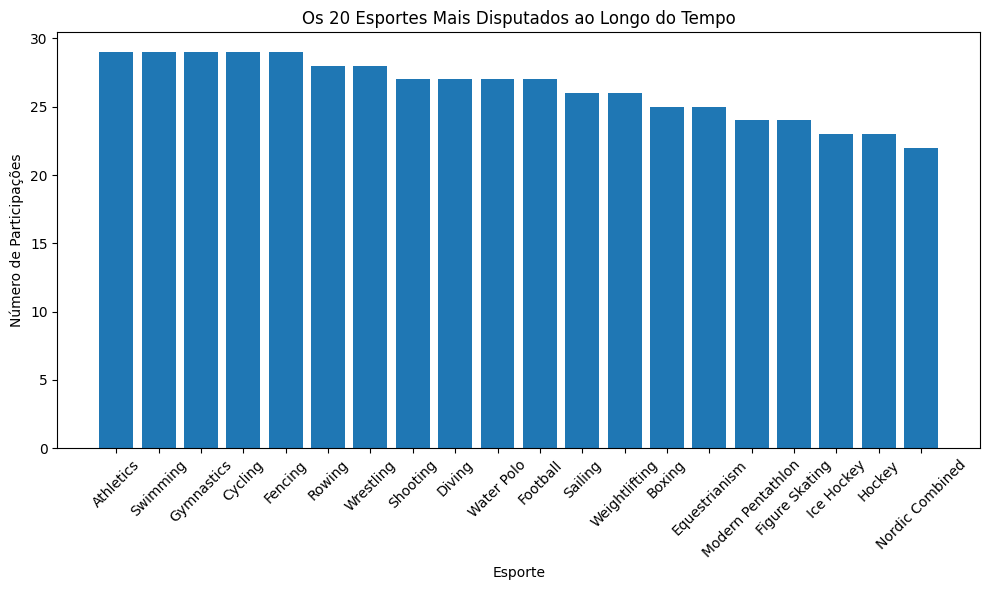

In [0]:
# Consulta SQL para obter os 20 esportes mais disputados ao longo do tempo
df_esportes = spark.sql("SELECT Sport, COUNT(DISTINCT CONCAT(Year, Sport)) AS Participacoes FROM athlete_events_5_csv GROUP BY Sport ORDER BY Participacoes DESC LIMIT 20")

# Converter o resultado da consulta para um DataFrame pandas
df_pandas = df_esportes.toPandas()

# Gerar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_pandas['Sport'], df_pandas['Participacoes'])
plt.xlabel('Esporte')
plt.ylabel('Número de Participações')
plt.title('Os 20 Esportes Mais Disputados ao Longo do Tempo')

# Exibir o gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#6. Autoavaliação

Para a organização desse trabalho, os pontos mais críticos referem-se a longa distribuição do tempo da amostra, possibilitando a incosistência de muitas informações. 

Algumas ausências não tinham tratamentos possíveis, no entanto, o volume reduzido o período em que estavam relacionados eram previstos e reduzidos.

De maneira geral, a pesquisa foi facilitada pela estrutura de informação em uma tabela única, com concentração das informações mais relevantes, o que limitou a necessidade de correções mais específicas no dataset, com exceção da coluna de peso, que poderia impactar as análises.